# Sentiment Analysis on stock tweets data BERT




## Exploratory Data Analysis

In [43]:
!pip install torch
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [44]:

df = pd.read_csv('tweets_labelled_09042020_16072020.csv',sep=";").drop(columns={'created_at'}).rename(columns={'sentiment':'category'})
df.set_index('id', inplace = True)

In [45]:

df.head()

text  category
id                                                                 
77522   RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...  positive
661634  #SriLanka surcharge on fuel removed!\n⛽📉\nThe ...  negative
413231  Net issuance increases to fund fiscal programs...  positive
760262  RT @bentboolean: How much of Amazon's traffic ...  positive
830153  $AMD Ryzen 4000 desktop CPUs looking ‘great’ a...  positive

In [46]:
import pandas as pd
import re

def remove_emoji(text):

  emoji_pattern = r"[^\w\s]"  # Matches any character that is not a word character or whitespace
  return re.sub(emoji_pattern, '', text)

# Apply the remove_emoji function to the 'text' column
df['text'] = df['text'].apply(remove_emoji)

In [47]:
df.head()

text  category
id                                                                 
77522   RT RobertBeadles Yo\nEnter to WIN 1000 Monarch...  positive
661634  SriLanka surcharge on fuel removed\n\nThe surc...  negative
413231  Net issuance increases to fund fiscal programs...  positive
760262  RT bentboolean How much of Amazons traffic is ...  positive
830153  AMD Ryzen 4000 desktop CPUs looking great and ...  positive

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 77522 to 301411
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      5000 non-null   object
 1   category  1300 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [49]:

df.isnull().sum()

text           0
category    3700
dtype: int64

In [50]:
df.shape

(5000, 2)

In [51]:
df = df.dropna()

In [52]:
df.shape

(1300, 2)

In [53]:
df.isnull().sum()

text        0
category    0
dtype: int64

In [54]:
df.text.iloc[10]

'RT PipsToDollars Earnings AMZN TSLA MSFT AAPL AMD BA FB LUV MMM GE AAL UPS TWTR PFE CBSH PEP MA GOOGL GILD SBUX UAL'

In [55]:

df.category.value_counts()

positive    528
neutral     424
negative    348
Name: category, dtype: int64

In [56]:

df = df[~df.category.str.contains('\|')]

In [57]:

df = df[df.category != 'nocode']

In [58]:

df.category.value_counts()

positive    528
neutral     424
negative    348
Name: category, dtype: int64

<ipython-input-59-26ca9671e243>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df.category, palette='Spectral')


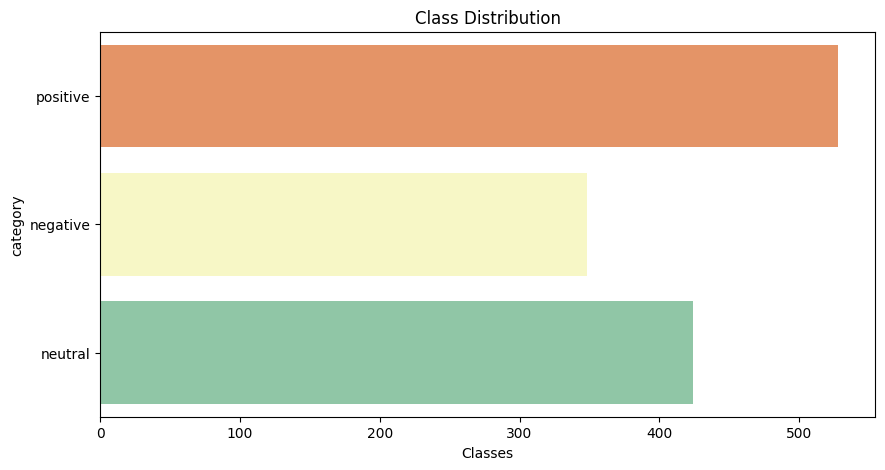

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 5))
sns.countplot(df.category, palette='Spectral')
plt.xlabel('Classes')
plt.title('Class Distribution');

In [60]:

possible_labels = df.category.unique()
possible_labels

array(['positive', 'negative', 'neutral'], dtype=object)

In [61]:

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [62]:
label_dict

{'positive': 0, 'negative': 1, 'neutral': 2}

In [63]:

df['label'] = df.category.replace(label_dict)
df.head(10)

text  category  label
id                                                                        
77522   RT RobertBeadles Yo\nEnter to WIN 1000 Monarch...  positive      0
661634  SriLanka surcharge on fuel removed\n\nThe surc...  negative      1
413231  Net issuance increases to fund fiscal programs...  positive      0
760262  RT bentboolean How much of Amazons traffic is ...  positive      0
830153  AMD Ryzen 4000 desktop CPUs looking great and ...  positive      0
27027   RT QuantTrend Reduce your portfolio RISK GOLD ...  positive      0
472959  86369 Million in Sales Expected for Spirit Aer...  positive      0
392845  RT ArjunKharpal Apple has cut the prices of th...  negative      1
313771  RT SMA_alpha The CDC US New Case data has a 2 ...  negative      1
267894  Where to Look for Dependable Dividends\nRead M...   neutral      2

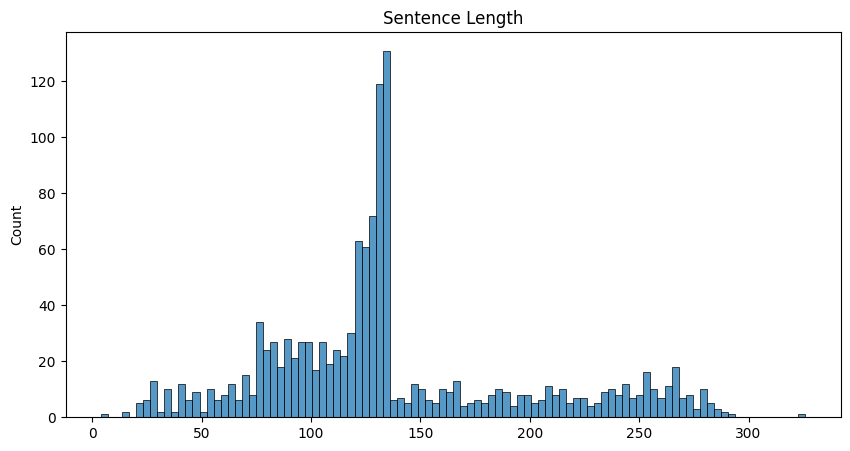

In [64]:

plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.text], bins=100)
plt.title('Sentence Length')
plt.show()

In [65]:
max_len = max([len(sent) for sent in df.text])
print('Max length: ', max_len)

Max length:  326


## Train Test Split

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                   df.label.values,
                                                   test_size = 0.15,
                                                   random_state = 17,
                                                   stratify = df.label.values)

In [67]:
df['data_type'] = ['not_set'] * df.shape[0]
df.head()

text  category  label  \
id                                                                           
77522   RT RobertBeadles Yo\nEnter to WIN 1000 Monarch...  positive      0   
661634  SriLanka surcharge on fuel removed\n\nThe surc...  negative      1   
413231  Net issuance increases to fund fiscal programs...  positive      0   
760262  RT bentboolean How much of Amazons traffic is ...  positive      0   
830153  AMD Ryzen 4000 desktop CPUs looking great and ...  positive      0   

       data_type  
id                
77522    not_set  
661634   not_set  
413231   not_set  
760262   not_set  
830153   not_set

In [68]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [69]:
df.groupby(['category', 'label', 'data_type']).count()

text
category label data_type      
negative 1     train       296
               val          52
neutral  2     train       360
               val          64
positive 0     train       449
               val          79

## Tokenization

In [70]:
!pip install transformers

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [71]:
# tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english",
#                                          do_lower_case = True)

In [72]:
from transformers import RobertaTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

model_name = "roberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].text.values.tolist(),
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                truncation=True,
                                                max_length = 150,
                                                return_tensors = 'pt')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [74]:
encoded_data_val = tokenizer.batch_encode_plus(df[df.data_type == 'val'].text.values.tolist(),
                                                #add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                truncation=True,
                                                max_length = 150,
                                                return_tensors = 'pt')

In [75]:
encoded_data_train

{'input_ids': tensor([[  101, 19387,  2728,  ...,     0,     0,     0],
        [  101,  5185,  5802,  ...,     0,     0,     0],
        [  101,  5658, 26354,  ...,     0,     0,     0],
        ...,
        [  101, 19387,  5003,  ...,     0,     0,     0],
        [  101,  9779, 24759,  ...,     0,     0,     0],
        [  101,  1043,  2140,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

## Encoding

In [76]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

In [78]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

labels_val = torch.tensor(df[df.data_type == 'val'].label.values)

In [79]:
input_ids_train

tensor([[  101, 19387,  2728,  ...,     0,     0,     0],
        [  101,  5185,  5802,  ...,     0,     0,     0],
        [  101,  5658, 26354,  ...,     0,     0,     0],
        ...,
        [  101, 19387,  5003,  ...,     0,     0,     0],
        [  101,  9779, 24759,  ...,     0,     0,     0],
        [  101,  1043,  2140,  ...,     0,     0,     0]])

In [80]:
attention_masks_train

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [81]:
labels_train

tensor([0, 1, 0,  ..., 2, 0, 1])

In [82]:
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val,
                             attention_masks_val,
                             labels_val)

In [83]:
print(len(dataset_train))
print(len(dataset_val))

1105
195


In [84]:
dataset_train

In [85]:
dataset_train.tensors

(tensor([[  101, 19387,  2728,  ...,     0,     0,     0],
         [  101,  5185,  5802,  ...,     0,     0,     0],
         [  101,  5658, 26354,  ...,     0,     0,     0],
         ...,
         [  101, 19387,  5003,  ...,     0,     0,     0],
         [  101,  9779, 24759,  ...,     0,     0,     0],
         [  101,  1043,  2140,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 1, 0,  ..., 2, 0, 1]))

## Set Up BERT Pretrained Model

In [142]:
# from transformers import DistilBertForSequenceClassification, DistilBertConfig

# # Load the model with ignore_mismatched_sizes=True
# model = DistilBertForSequenceClassification.from_pretrained(
#     "roberta-large-mnli",
#     num_labels=len(label_dict),  # Your specific number of labels
#     output_attentions=False,
#     output_hidden_states=False,
#     ignore_mismatched_sizes=True  # Ignore the size mismatch during loading
# )

# # Optional: Re-initialize the classifier layer if needed
# config = DistilBertConfig.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", num_labels=len(label_dict))
# model.classifier = torch.nn.Linear(config.dim, config.num_labels)


from transformers import RobertaForSequenceClassification, RobertaConfig
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

# Load the pre-trained model configuration
# config = RobertaConfig.from_pretrained("roberta-large-mnli")

# Update the number of labels in the configuration to match your task
num_labels = len(label_dict)  # Your specific number of labels
# config.num_labels = num_labels

# # Load the model with updated configuration
# model = RobertaForSequenceClassification(config)

# # (Optional) If you need to specifically re-initialize the classifier layer:
# model.classifier = torch.nn.Linear(config.hidden_size, num_labels)



# Load the model with ignore_mismatched_sizes=True
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_dict),  # Your specific number of labels
    output_attentions=False,
    output_hidden_states=False,
    ignore_mismatched_sizes=True  # Ignore the size mismatch during loading
)

# Optional: Re-initialize the classifier layer if needed
config = AutoConfig.from_pretrained(model_name, num_labels=len(label_dict))
# model.classifier = torch.nn.Linear(config.dim, config.num_labels)
model.classifier = torch.nn.Linear(config.hidden_size, num_labels)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [143]:
model.config

BertConfig {
  "_name_or_path": "huawei-noah/TinyBERT_General_4L_312D",
  "attention_probs_dropout_prob": 0.1,
  "cell": {},
  "classifier_dropout": null,
  "emb_size": 312,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1200,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "structure": [],
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Create Data Loaders

In [144]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4

dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = 4)

dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32) #since we don't have to do backpropagation for this step

## Set Up Optimizer and Scheduler

In [145]:
from transformers import AdamW, get_linear_schedule_with_warmup
epochs = 10

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) #2e-5 > 5e-5

In [146]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

## Define Performance Metrics

In [147]:
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [148]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [149]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(dataloader_val):

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():
            outputs = model(**inputs)

        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

## Train Model

In [150]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [151]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
model.to(device)
print(device)

cuda


In [152]:
for epoch in tqdm(range(1, epochs+1)):

    #set model in train mode
    model.train()

    #tracking variable
    loss_train_total = 0

    #set up progress bar
    progress_bar = tqdm(dataloader_train,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)

    for batch in progress_bar:
        #set gradient to 0
        model.zero_grad()

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)
        loss = outputs[0] #output.loss
        loss_train_total +=loss.item()

        #backward pass to get gradients
        loss.backward()

        #clip the norm of the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        #update optimizer
        optimizer.step()

        #update scheduler
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    tqdm.write('\nEpoch {epoch}')

    #print training result
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    #evaluate
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    #f1 score
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/277 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 1.038994406965235


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.9215627568108695
F1 Score (weighted): 0.5829472936580913


Epoch 2:   0%|          | 0/277 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.8813978244251293


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7931978191648211
F1 Score (weighted): 0.6794993863389941


Epoch 3:   0%|          | 0/277 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.7816109903667808


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.8163649695260184
F1 Score (weighted): 0.6715066664247131


Epoch 4:   0%|          | 0/277 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.6966422562779933


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7653515083449227
F1 Score (weighted): 0.6813345747251063


Epoch 5:   0%|          | 0/277 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.6339987528776003


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7383314626557487
F1 Score (weighted): 0.7016215400473966


Epoch 6:   0%|          | 0/277 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.601340010385651


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7191258754049029
F1 Score (weighted): 0.724237295271778


Epoch 7:   0%|          | 0/277 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.5501129930899462


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7563585213252476
F1 Score (weighted): 0.7233669753853709


Epoch 8:   0%|          | 0/277 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.5389804588597173


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.6890379105295453
F1 Score (weighted): 0.7306488443330549


Epoch 9:   0%|          | 0/277 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.5075464965741987


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7764297340597425
F1 Score (weighted): 0.7263551548166932


Epoch 10:   0%|          | 0/277 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.4885033479881631


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.8376120839800153
F1 Score (weighted): 0.7355562541320929


AUC/ROC Plots

In [154]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle


n_classes = true_vals.max() + 1  # Adjust based on your labels
y_true_binarized = label_binarize(true_vals, classes=range(n_classes))


In [155]:
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()

for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_true_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


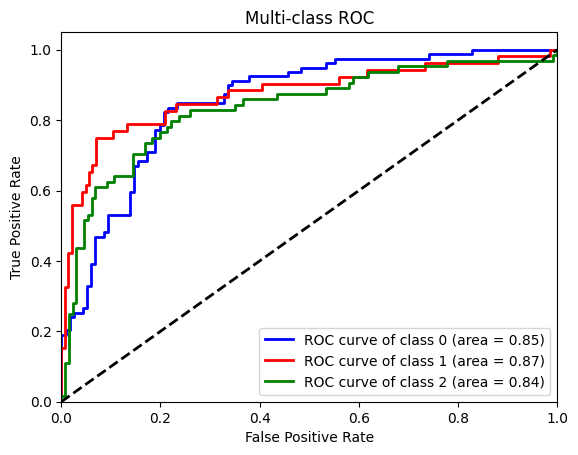

In [156]:
colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()


## Model Evaluation


In [157]:
outputs.loss

tensor(0.0921, device='cuda:0', grad_fn=<NllLossBackward0>)

In [158]:
outputs.logits

tensor([[ 2.1948, -1.3982, -0.4791]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [159]:
model.to(device)
pass

In [160]:
_, predictions, true_vals = evaluate(dataloader_val)

  0%|          | 0/7 [00:00<?, ?it/s]

In [161]:
accuracy_per_class(predictions, true_vals)

Class: positive
Accuracy:66/79

Class: negative
Accuracy:39/52

Class: neutral
Accuracy:39/64



In [162]:
# Assuming `predictions` is an array of logits from your model
predicted_labels = np.argmax(predictions, axis=1)
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Ensure `true_vals` contains your true labels

# Calculate Precision (for multi-class, set the average type)
precision = precision_score(true_vals, predicted_labels, average='weighted') # or 'macro'
print(f"Precision: {precision}")

# Calculate Recall (for multi-class, set the average type)
recall = recall_score(true_vals, predicted_labels, average='weighted') # or 'macro'
print(f"Recall: {recall}")

# Calculate Accuracy
accuracy = accuracy_score(true_vals, predicted_labels)
print(f"Accuracy: {accuracy}")


Precision: 0.7449612440135003
Recall: 0.7384615384615385
Accuracy: 0.7384615384615385


SHAP

In [163]:
!pip install shap
!pip install nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00


In [164]:
import nlp
import numpy as np
import scipy as sp
import torch
import transformers

import shap


# Define a prediction function
def f(x):
    # Tokenize the input text with padding and truncation
    tv = torch.tensor(
        [tokenizer.encode(v, padding="max_length", max_length=500, truncation=True) for v in x]
    ).cuda()

    # Get model outputs and convert to logits
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:, 1])  # use one vs rest logit units
    return val


# Load your dataset (assuming it's a Pandas DataFrame)
# data = pd.read_csv("your_dataset.csv")  # Replace with your data loading method

# Select text and sentiment label columns (assuming 'text' and 'label')
texts = df["text"].tolist()
labels = df["category"].tolist()  # Adjust column names if needed

# Create an explainer using the token masker
explainer = shap.Explainer(f, tokenizer)

# Explain the model's predictions on a subset of your dataset
shap_values = explainer(texts[:50], fixed_context=1)  # Explain first 10 samples

print(shap_values.shape)


# Visualize SHAP values (e.g., summary plot or force plot)
# shap.summary_plot(shap_values, texts[:10])


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
PartitionExplainer explainer: 51it [00:34,  1.08it/s]

(50, None)


In [165]:
shap.plots.text(shap_values[1])

In [166]:
labels[0]

'positive'

In [167]:
shap.plots.text(shap_values[1])

In [168]:
labels[1]

'negative'

In [169]:
shap.plots.text(shap_values[7])

In [170]:
labels[7]

'negative'

In [171]:
shap.plots.text(shap_values[9])

In [172]:
labels[9]

'neutral'

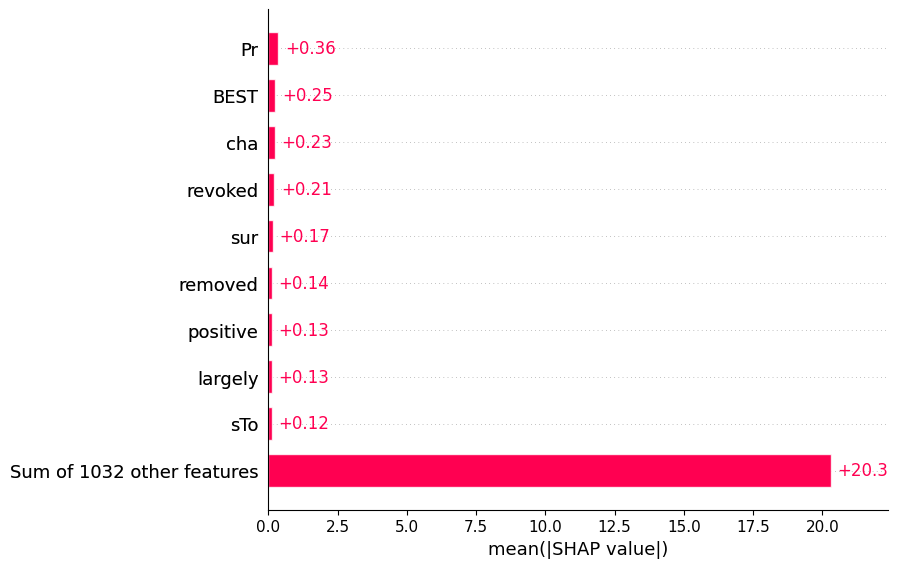

In [173]:
shap.plots.bar(shap_values)

# **LIME**

In [174]:
!pip install lime
!pip install explainers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=fff05052b728eaa5811b81f68f73e0474697f1ccf6608433ecd34bac2869f88f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
ERROR: Could not find a version that satisfies the requirement explainers (from versions: none)
ERROR: No matching distribution found for explainers


In [175]:
import lime
from lime.lime_text import LimeTextExplainer
import torch.nn.functional as F

model.to('cpu')


def predictor(texts):
    # Tokenize the input texts
    inputs = tokenizer(texts, return_tensors="pt", padding=True)

    # Move the tensors to the same device as the model
#     inputs = {k: v.to(model.device) for k, v in inputs.items()}
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Get the model outputs
    outputs = model(**inputs)

    # Apply softmax to get probabilities
    probas = F.softmax(outputs.logits, dim=1).detach().cpu().numpy()

    return probas

texts = df["text"].tolist()
labels = df["category"].tolist()

class_names = ['positive', 'negative', 'neutral']
lime_explainer = LimeTextExplainer(class_names=class_names)
exp = lime_explainer.explain_instance(texts[0], predictor, num_features=20, num_samples=500)

exp.show_in_notebook(text=True)




In [176]:
exp.show_in_notebook(text=True, labels=(exp.available_labels()[0],))
